<a href="https://colab.research.google.com/github/SuccessPear/PyTorch-for-Deep-Learning/blob/main/02_neural_network_classification/02_neural_network_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 02. Neural network classification with PyTorch

Classification is a problem of predicting whether something is one thing or another

## 1. Make classification data

In [1]:
import sklearn

In [2]:
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

# Create cricles
X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

In [3]:
len(X), len(y)

(1000, 1000)

In [4]:
print(f"First 5 samples of X: {X[:5]}")
print(f"First 5 samples of y: {y[:5]}")

First 5 samples of X: [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y: [1 1 1 1 0]


In [5]:
# Make dataframe of circle data
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
                        "X2": X[:, 1],
                        "label": y})
circles.head(5)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


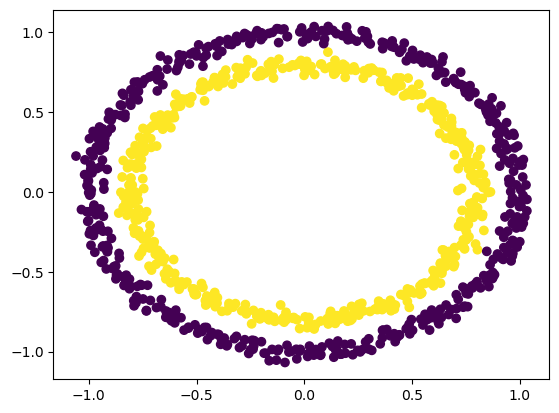

In [5]:
# Visualize
import matplotlib.pyplot as plt
plt.scatter(x=X[:,0],
            y=X[:,1],
            c=y)

### 1.1 Check input and output shapes

In [7]:
X.shape, y.shape

((1000, 2), (1000,))

In [8]:
# View the first example of features and lables
X_sample = X[0]
y_sample = y[0]

print(f"Values for one smaple of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one smaple of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


### 1.2 Turn data into tensors and create train and test splits

In [9]:
import torch
torch.__version__

'2.2.1+cu121'

In [10]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [11]:
# Split the data into train and test set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
len(X_train), len(X_test)

(800, 200)

## 2. Building a model

Build a model to classify 2 circles

Steps:
1. Setup device agonistic code
2. Construct a model (by subclassing nn.Module)
3. Define a loss function and optimizer
4. Create a training and test loop

In [13]:
# Import PyTorch and nn
import torch
from torch import nn

# Make device aginostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

1. Subclass `nn.Module`
2. Create 2 nn.Linear() laylerss
3. Defines a forward() method that outlines the forward pass of the model
4. Instatiate an instance of out model class and send it to the target device

In [14]:
input_feature = X.shape[1]
output_feature = 1
# Create model class that subclassed nn.Model
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    # Create 2 nn.Linear() layers
    self.linear_1 = nn.Linear(in_features=input_feature,
                             out_features=5)
    self.linear_2 = nn.Linear(in_features=5,
                             out_features=output_feature)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    out1 = self.linear_1(x)
    return self.linear_2(out1)

In [15]:
model_0 = CircleModelV0()
model_0.to(device)

CircleModelV0(
  (linear_1): Linear(in_features=2, out_features=5, bias=True)
  (linear_2): Linear(in_features=5, out_features=1, bias=True)
)

In [16]:
next(model_0.parameters()).device

device(type='cpu')

In [17]:
## Replicate the model above using nn.Sequential
model_1 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

In [18]:
model_0.state_dict()

OrderedDict([('linear_1.weight',
              tensor([[ 0.2772,  0.4400],
                      [ 0.7020, -0.0156],
                      [-0.5076,  0.4732],
                      [ 0.5655, -0.2767],
                      [-0.2963, -0.1049]])),
             ('linear_1.bias',
              tensor([ 0.1563, -0.6079, -0.1605,  0.6303, -0.4119])),
             ('linear_2.weight',
              tensor([[ 0.2930,  0.4198,  0.1884, -0.2212, -0.1161]])),
             ('linear_2.bias', tensor([0.1102]))])

In [19]:
with torch.inference_mode():
  y_pred = model_0(X_test)


### 2.1 Setup loss function and optimizer

Which loss function or optimizer should you use?

This is problem specific.

For Regression you might want MAE or MSE

For Classification you might want binary  cross entropy or categorical cross entropy

And for optimizer, two of the most common and useful are adam and sgd

For loss function, we will use torch.nn.BCEWithLogitsLoss()

In [20]:
# Setup the loss function
loss_fn = torch.nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [21]:
# Calculate accuracy - out of 100 examples, what percentage does our model get right?
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = correct / len(y_pred) * 100
  return acc

## 3. Train
To train our model, we're going to need to build a training loop
1. Forward pass
2. Calculate the loss
3. Optimizer zero grad
4. Loss backward
5. Optimizer step (gradient descent)

### 3.1 Going from raw logits -> prediction probabilities -> prediction labels

Our model outputs are going to be raw **logits**

We can convert these **logits** into **prediction probabilities** by passing them to some kind of activation function (e.g sigmoid for binary classification and soft max for multiclass classification)

Then we can convert our model's prediction probabilities to **prediction labels** by either rounding them or taking the `argmax()`

In [22]:
# View the first 5 outputs of the forward pass on the test data
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-9.7732e-02],
        [ 5.5349e-02],
        [-4.4400e-01],
        [ 1.5416e-04],
        [-3.5667e-01]])

In [23]:
# Use the sigmoid actication function on our logits to turn them into probabilities
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4756],
        [0.5138],
        [0.3908],
        [0.5000],
        [0.4118]])

For our prediction probability values, we need to perform a range-style rounding on them:
* `y_pred_prob` >= 0.5 then y=1 (class 1)
* `y_pred_prob` < 0.5 then y=0 (class 0)

In [24]:
# Find the predicted labels
y_preds = torch.round(y_pred_probs)

# In full (logits -> pred probs -> pred labels)
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True])


tensor([0., 1., 0., 1., 0.])

In [25]:
### 3.2 Building a training loop

torch.manual_seed(42)
# Define number of epochs
epochs = 100

# Move dataset to correct device
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

# Building a for loop

for epoch in range(epochs):
  ### Training
  model_0.train()

  # Forward pass
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.relu(y_logits)) # turn logits -> pred probs -> pred labels

  # Calculate loss / accuracy
  # loss_fn(torch.sigmoid(y_logits), y_train) # nn.BCELoss expects prediction probabilities
  loss = loss_fn(y_logits, y_train) # nn.BCEWithLogitsLoss expect y_logits not y_preds
  acc = accuracy_fn(y_pred, y_train)

  # Optimizer zero grad
  optimizer.zero_grad()

  # Loss backward (back propagation)
  loss.backward()

  # Optimizer step
  optimizer.step()

  ### Testing
  model_0.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.relu(test_logits))

    # 2. Calculate test loss/acc
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)

  # Print
  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f}% | Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.70338 | Acc: 50.00% | Test loss: 0.71170 | Test acc: 50.00%
Epoch: 10 | Loss: 0.69840 | Acc: 50.00% | Test loss: 0.70711 | Test acc: 50.00%
Epoch: 20 | Loss: 0.69657 | Acc: 50.00% | Test loss: 0.70516 | Test acc: 50.00%
Epoch: 30 | Loss: 0.69575 | Acc: 50.00% | Test loss: 0.70403 | Test acc: 50.00%
Epoch: 40 | Loss: 0.69528 | Acc: 50.00% | Test loss: 0.70321 | Test acc: 50.00%
Epoch: 50 | Loss: 0.69496 | Acc: 50.00% | Test loss: 0.70253 | Test acc: 50.00%
Epoch: 60 | Loss: 0.69471 | Acc: 50.00% | Test loss: 0.70194 | Test acc: 50.00%
Epoch: 70 | Loss: 0.69450 | Acc: 50.00% | Test loss: 0.70143 | Test acc: 50.00%
Epoch: 80 | Loss: 0.69433 | Acc: 50.00% | Test loss: 0.70096 | Test acc: 50.00%
Epoch: 90 | Loss: 0.69419 | Acc: 50.00% | Test loss: 0.70054 | Test acc: 50.00%


## 4. Make predictions and evaluate the model

From the metrics it look like our model isn't learning anything..

So to inspect it let's make some predictions and make them viasual

To do so, we will import a function called `plot_decision_boundary()`

In [26]:
import requests
from pathlib import Path

# Download helper functions from Learn Pytorch repo
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Download helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

Download helper_functions.py


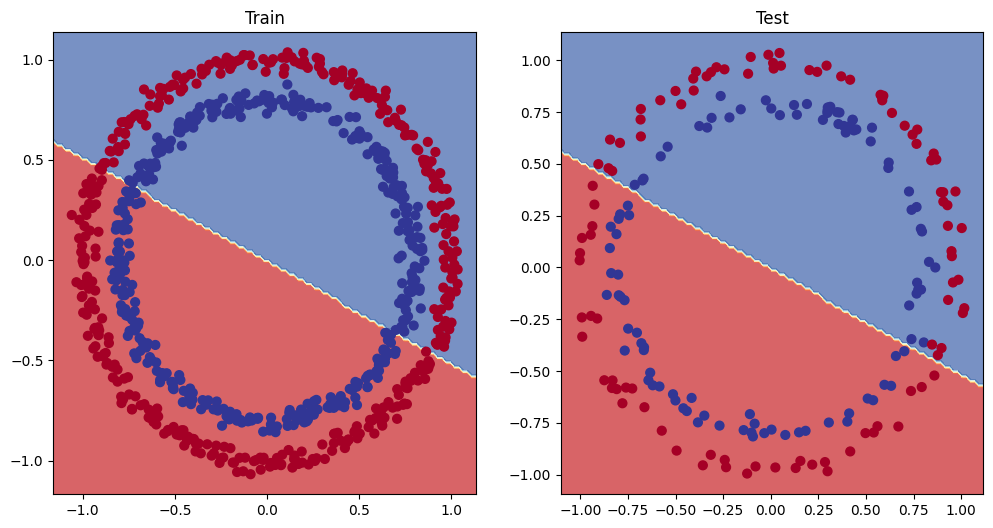

In [27]:
# Plot decision boundary of the model
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

## 5. Improving a model (from a model perspective)

* Add more layers - give the model more chances to learn about patterns in the data
* Add more hidden units - go from 5 units to 10, 20, 30,... units
* Train longer
* Changing the activation functions
* Change the learning rate
* Change the loss function

These options are all from a model's perspective because they deal directly with the model, rather than the data

And because these options are all values we (as machine learning engineers) can change, they are referred to **hyper parameters**

Let's try and improve our model by:
* Adding more hidden units: 5->10
* Increase the number of layers: 2->3
* Increase the number of epochs: 100->1000

**We should change 1 hyper parameters at a time to know which hyperparameters are affecting the model**

In [28]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.relu = nn.Sigmoid()
    self.layer_3 = nn.Linear(in_features=10, out_features=1)

  def forward(self, x):
    # z = self.layer_1(x)
    # z = self.layer_2(z)
    # z = self.layer_3(z)
    # return z
    return self.layer_3(self.relu(self.layer_2(self.layer_1(x)))) # This way speed ups where possible behind the screen

model_1 = CircleModelV1().to(device)

In [29]:
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (relu): Sigmoid()
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [30]:
# Create a loss function
loss_fn = nn.BCEWithLogitsLoss()

# Create an optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1)

In [31]:
# Write a training and evaluation loop for model_1
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Train for longer
epochs = 1000

# Put data on the target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  ### Training
  model_1.train()
  # 1. Forward pass
  y_logits = model_1(X_train).squeeze()
  y_preds = torch.round(torch.sigmoid(y_logits))

  # 2. Calculate loss/acc
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_preds)

  # 3. Zero grad
  optimizer.zero_grad()

  # 4. Loss backward
  loss.backward()

  # 5. Optimizer step
  optimizer.step()

  ### Test
  model_1.eval()
  with torch.inference_mode():
    test_logits = model_1(X_test).squeeze()
    test_preds = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_preds)

  if epoch % 50 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f}% | Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69993 | Acc: 50.00% | Test loss: 0.69841 | Test acc: 50.00%
Epoch: 50 | Loss: 0.69321 | Acc: 50.38% | Test loss: 0.69303 | Test acc: 50.00%
Epoch: 100 | Loss: 0.69319 | Acc: 50.62% | Test loss: 0.69308 | Test acc: 49.00%
Epoch: 150 | Loss: 0.69318 | Acc: 50.25% | Test loss: 0.69312 | Test acc: 48.50%
Epoch: 200 | Loss: 0.69316 | Acc: 49.88% | Test loss: 0.69316 | Test acc: 51.00%
Epoch: 250 | Loss: 0.69315 | Acc: 49.25% | Test loss: 0.69320 | Test acc: 54.00%
Epoch: 300 | Loss: 0.69314 | Acc: 49.75% | Test loss: 0.69324 | Test acc: 52.00%
Epoch: 350 | Loss: 0.69313 | Acc: 49.00% | Test loss: 0.69328 | Test acc: 51.00%
Epoch: 400 | Loss: 0.69312 | Acc: 50.00% | Test loss: 0.69332 | Test acc: 50.00%
Epoch: 450 | Loss: 0.69311 | Acc: 50.00% | Test loss: 0.69336 | Test acc: 51.00%
Epoch: 500 | Loss: 0.69310 | Acc: 50.50% | Test loss: 0.69340 | Test acc: 49.50%
Epoch: 550 | Loss: 0.69309 | Acc: 51.00% | Test loss: 0.69343 | Test acc: 47.50%
Epoch: 600 | Loss: 0.69308 | Ac

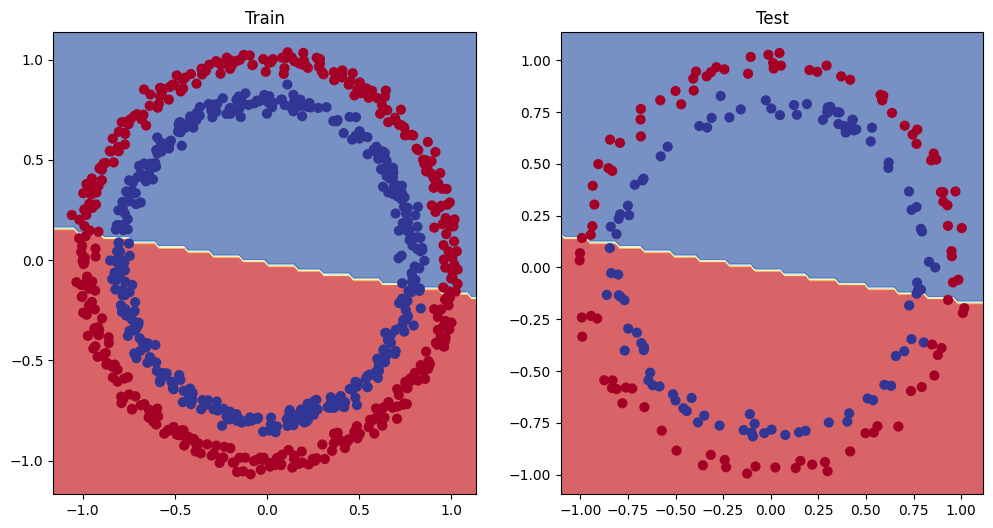

In [32]:
# Plot decision boundary of the model
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

### 5.1 Preparing data to see if our data can fit a straight line

One way to troubleshoot to a larger problem is to test out a smaller problem

In [33]:
# Create some data
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# Create data
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias

# Check the data
print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [34]:
# Create train and test split
train_split = int(0.8 *len(X_regression))
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

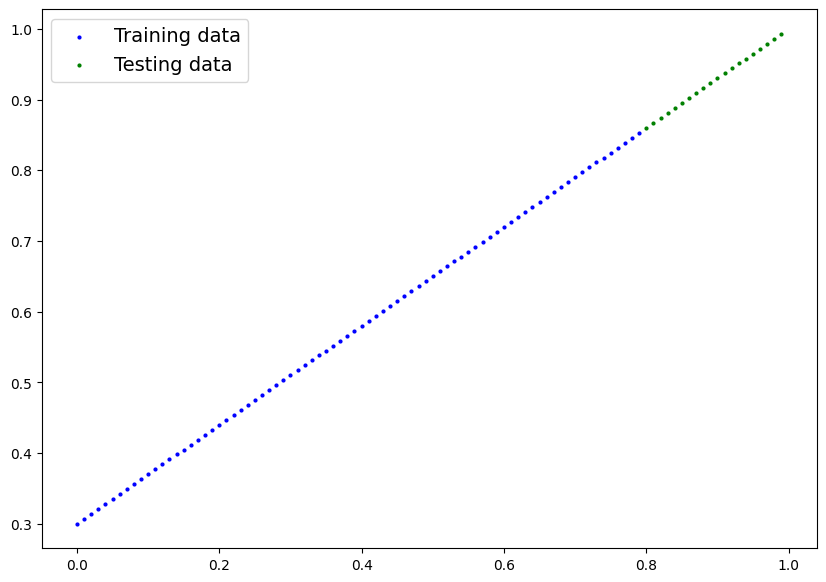

In [35]:
plot_predictions(X_train_regression, y_train_regression, X_test_regression, y_test_regression)

### 5.2 Adjusting `model_1` to fit a straight line

In [36]:
# Same architecture as model_1
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [37]:
# Loss and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr=0.1)

In [38]:
# Train the model
torch.manual_seed(42)

epoch = 1000

X_train_regression.to(device), y_train_regression.to(device)
X_test_regression.to(device), y_test_regression.to(device)

for epoch in range(epochs):
  ### Training
  model_2.train()

  # 1. Forward pass
  y_pred = model_2(X_train_regression)

  # 2. Calculate loss / acc
  loss = loss_fn(y_pred, y_train_regression)

  # 3
  optimizer.zero_grad()

  loss.backward()

  optimizer.step()
  ### Test
  model_2.eval()
  with torch.inference_mode():
    test_pred = model_2(X_test_regression)
    test_loss = loss_fn(test_pred, y_test_regression)

  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss:{loss:.5f} | Test loss: {test_loss:.5f}")

Epoch: 0 | Loss:0.75986 | Test loss: 0.54143
Epoch: 100 | Loss:0.09309 | Test loss: 0.02901
Epoch: 200 | Loss:0.07376 | Test loss: 0.02850
Epoch: 300 | Loss:0.06745 | Test loss: 0.00615
Epoch: 400 | Loss:0.06107 | Test loss: 0.02004
Epoch: 500 | Loss:0.05698 | Test loss: 0.01061
Epoch: 600 | Loss:0.04857 | Test loss: 0.01326
Epoch: 700 | Loss:0.06109 | Test loss: 0.02127
Epoch: 800 | Loss:0.05600 | Test loss: 0.01425
Epoch: 900 | Loss:0.05571 | Test loss: 0.00603


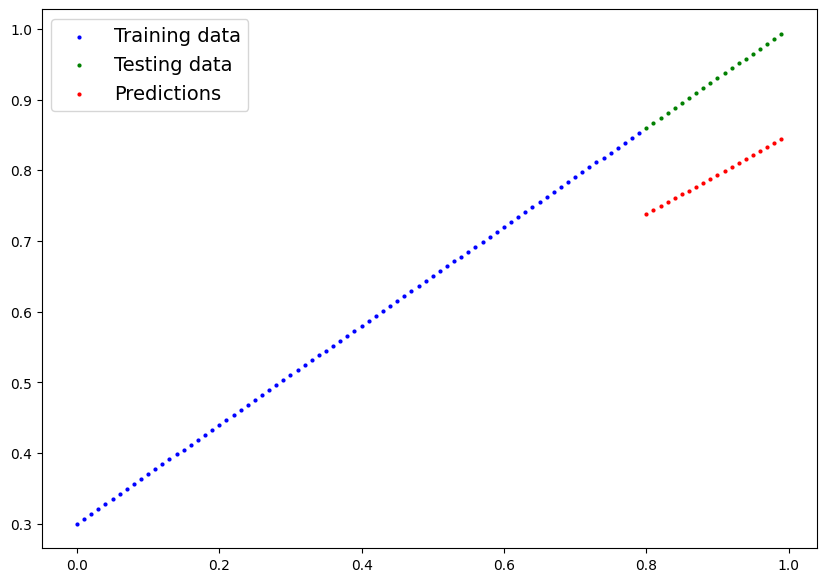

In [39]:
# Turn on evaluation
model_2.eval()
with torch.inference_mode():
  y_preds = model_2(X_test_regression)
plot_predictions(X_train_regression, y_train_regression, X_test_regression, y_test_regression, predictions=y_preds)

## 6. The missing piece: non-linearity

"What patterns could you draw if you were given an infinite amout of a straight and non-straight lines?"

Or in machine learning terms, an infinite (but really it is finite) of linear and non-linear functions?


In [40]:
### 6.1 Recreating non-linear data (red and blue ciricles)

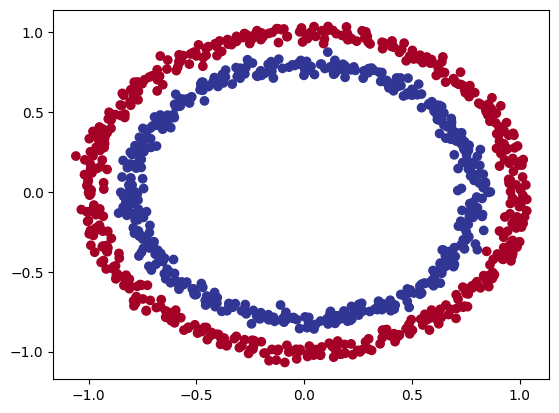

In [41]:
# Make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)

In [42]:
# Convert data to tensors and then to train and test split
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 6.2 Building a model with non-linearity

* Linear = straight line
* Non-linear = non-straight line

In [43]:
# Build a moedl with non-linear activation functions
from torch import nn
class CircleModelV3(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)
    self.relu = nn.ReLU() # relu is a non-linear activation function

  def forward(self, x):
    # Where should we put our non-linear activation function?
    return self.layer_3(self.relu(self.layer_2(self.layer_1(x))))

model_3 = CircleModelV3().to(device)
model_3

CircleModelV3(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [44]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_3.parameters(),
                            lr=0.1)

In [45]:
torch.manual_seed(42)

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

epochs = 1000

for epoch in range(epochs):
  model_3.train()

  y_logits = model_3(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  ### Testing
  model_3.eval()
  with torch.inference_mode():
    test_logits = model_3(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)

  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f}% | Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69833 | Acc: 50.00% | Test loss: 0.69863 | Test acc: 49.00%
Epoch: 100 | Loss: 0.69289 | Acc: 50.88% | Test loss: 0.69411 | Test acc: 47.00%
Epoch: 200 | Loss: 0.69015 | Acc: 53.37% | Test loss: 0.69141 | Test acc: 50.00%
Epoch: 300 | Loss: 0.68762 | Acc: 56.62% | Test loss: 0.68828 | Test acc: 55.00%
Epoch: 400 | Loss: 0.68469 | Acc: 60.00% | Test loss: 0.68469 | Test acc: 61.00%
Epoch: 500 | Loss: 0.67985 | Acc: 56.00% | Test loss: 0.67890 | Test acc: 60.50%
Epoch: 600 | Loss: 0.67280 | Acc: 56.00% | Test loss: 0.67176 | Test acc: 60.50%
Epoch: 700 | Loss: 0.66304 | Acc: 64.50% | Test loss: 0.66452 | Test acc: 65.00%
Epoch: 800 | Loss: 0.64710 | Acc: 74.12% | Test loss: 0.65300 | Test acc: 71.50%
Epoch: 900 | Loss: 0.62182 | Acc: 81.62% | Test loss: 0.63241 | Test acc: 78.00%


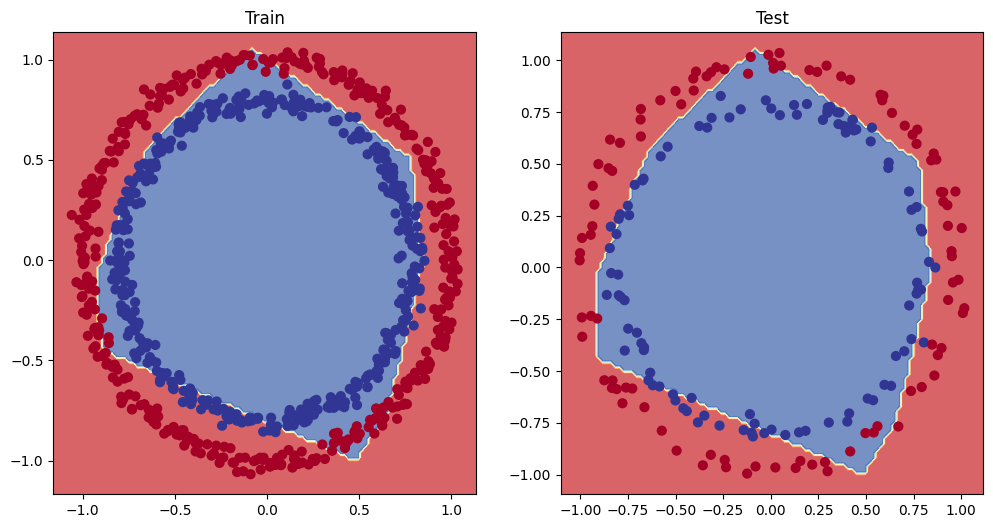

In [46]:
# Plot decision boundary of the model
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)

### 6.4 Evaluating a model trained with non-linear activation functions

In [47]:
# Make predictions
model_3.eval()
with torch.inference_mode():
  y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10], y_test[:10]

(tensor([1., 1., 1., 0., 1., 1., 0., 0., 1., 0.]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

## 7. Replicating non-linear activation function
Neural networks, rather than us tellingthe model what to learn, we give it the tools to discover patterns in data and it tries to figure out the patterns on it own

These tools are linear and non-linear functions

In [48]:
# Create a tensor
A = torch.arange(-10, 10, 1, dtype=torch.float32)
A.dtype

torch.float32

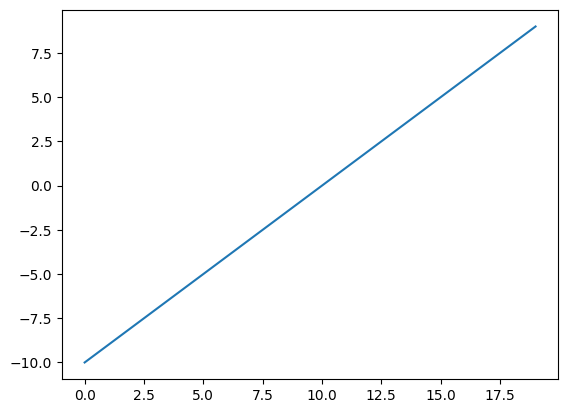

In [49]:
plt.plot(A)

In [50]:
def relu(x):
  return torch.maximum(torch.tensor(0), x)

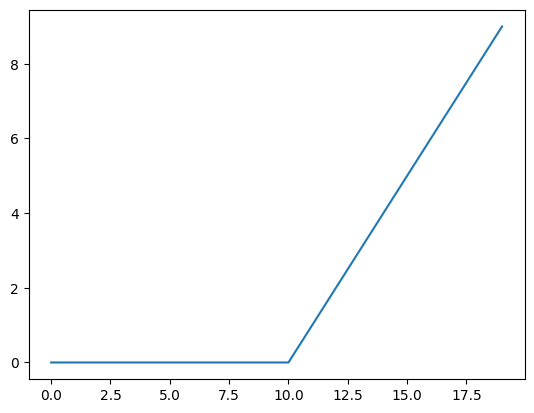

In [52]:
# Plot ReLU activation function
plt.plot(relu(A))

In [53]:
def sigmoid(x):
  return 1.0 / (1 + torch.exp(-x))

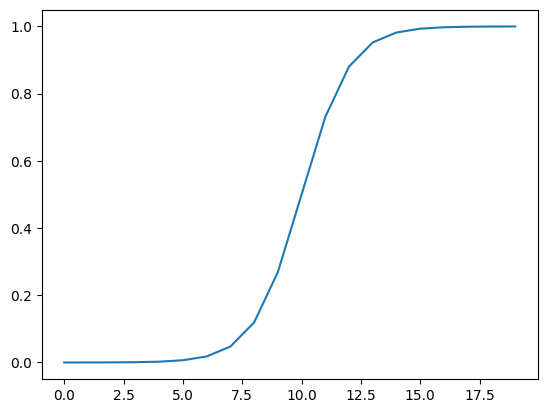

In [54]:
plt.plot(sigmoid(A))

## 8. Putting it all together with a multiclass classification problem
* Binary classification = one thing or another
* Multiclass classification = more than one thing or another

### 8.1 Creating a toy multi-class data set

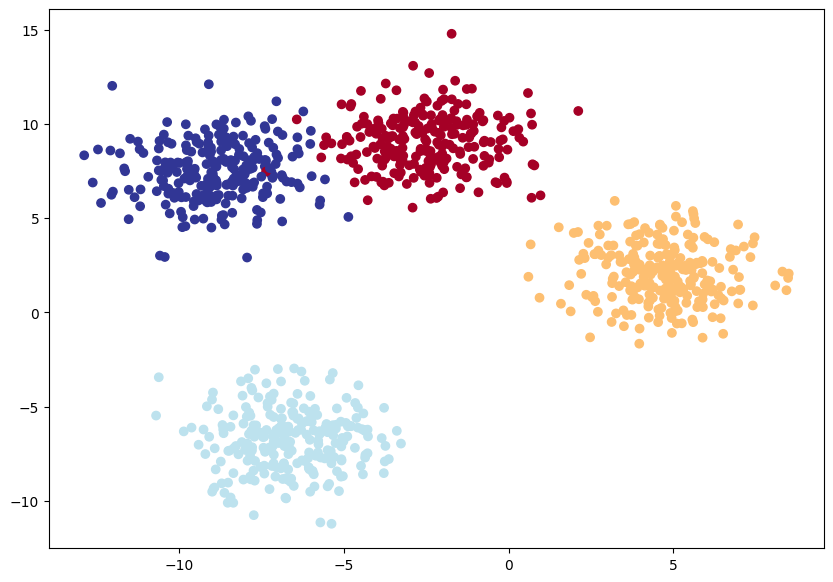

In [89]:
# Import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set hyperparameters
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5,
                            random_state=RANDOM_SEED)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.float)

# 3. Split into train and test
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob, y_blob, test_size=0.2, random_state=RANDOM_SEED)

# 4. Plot data
plt.figure(figsize=(10,7))
plt.scatter(X_blob[:,0], X_blob[:,1], c=y_blob, cmap=plt.cm.RdYlBu)

### 8.2 Buiding a multi-class classification model in PyTorch

In [90]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [126]:
# Build a multi-class classificaation model
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    """Initialize multi class classification model.

    Args:
      input_features (int): Number of input features to the model
      output_features (int): Number of output features to the model
      hidden_units (int): Number of hidden units between layers, default 8

    Returns:

    Example:
    """
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        # nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        # nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )
  def forward(self, x):
    return self.linear_layer_stack(x)

# Create an instace of BlobModel and send it to the target device
model_4 = BlobModel(input_features=2,
                    output_features=4,
                    hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [127]:
X_blob_train.shape

torch.Size([800, 2])

In [128]:
torch.unique(y_blob_train)

tensor([0., 1., 2., 3.])

### 8.3 Create a loss function and optimizer for multi-class classification

In [129]:
# Create a loss function
loss_fn = nn.CrossEntropyLoss()

# Create an optimizer
optimizer = torch.optim.SGD(params=model_4.parameters(),
                            lr=0.1)

### 8.4 Getting prediction probabilities for a multi-class PyTorch model

In order to evaluate and train and test our model, we need to convert our model's outputs (logits) to prediction probabilities and then prediction labels

In [130]:
X_blob_train.shape

torch.Size([800, 2])

In [131]:
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test.to(device))

In [132]:
# Convert our model's logits outputs to prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-0.5319,  1.0959,  1.0068,  0.5806],
        [ 1.9350, -2.5152, -1.2910,  0.4205],
        [ 0.8268, -0.7811, -0.7507, -1.5860],
        [-0.5279,  1.1172,  0.8837,  0.0760],
        [ 0.6607, -0.6869,  0.0588,  1.1909]])
tensor([[0.0725, 0.3692, 0.3377, 0.2205],
        [0.7866, 0.0092, 0.0312, 0.1730],
        [0.6683, 0.1339, 0.1380, 0.0599],
        [0.0826, 0.4278, 0.3387, 0.1510],
        [0.2851, 0.0741, 0.1562, 0.4846]])


In [133]:
# Convert our models' prediction probabilities to prediction labels
y_preds = torch.argmax(y_pred_probs, dim=1)

In [134]:
y_preds

tensor([1, 0, 0, 1, 3, 0, 0, 0, 0, 3, 0, 1, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 3, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3,
        0, 0, 1, 0, 2, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 3, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 3, 3, 1, 0,
        0, 0, 3, 1, 0, 0, 0, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 3, 1, 1, 1, 3, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 3, 0, 0, 0, 1, 0, 3, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 1])

In [135]:
y_blob_test

tensor([1., 3., 2., 1., 0., 3., 2., 0., 2., 0., 0., 1., 0., 0., 0., 3., 3., 2.,
        3., 3., 3., 0., 1., 2., 2., 2., 3., 0., 1., 0., 3., 1., 1., 3., 1., 2.,
        1., 3., 0., 2., 0., 3., 3., 2., 0., 3., 1., 1., 0., 3., 1., 0., 1., 1.,
        3., 2., 1., 1., 3., 2., 2., 0., 3., 2., 2., 0., 0., 3., 3., 0., 0., 3.,
        3., 3., 2., 3., 3., 3., 3., 1., 0., 2., 3., 2., 3., 3., 2., 3., 3., 2.,
        3., 3., 1., 3., 3., 3., 1., 0., 3., 2., 0., 0., 3., 0., 2., 3., 1., 0.,
        3., 2., 1., 1., 0., 2., 2., 3., 0., 0., 1., 2., 2., 3., 0., 1., 2., 0.,
        0., 0., 2., 3., 1., 2., 3., 2., 0., 3., 0., 0., 1., 1., 1., 0., 2., 2.,
        2., 2., 0., 3., 3., 2., 2., 1., 3., 2., 0., 0., 3., 3., 2., 1., 2., 0.,
        3., 2., 0., 3., 2., 0., 2., 2., 2., 0., 3., 1., 1., 1., 1., 1., 3., 1.,
        0., 2., 2., 1., 2., 2., 0., 1., 2., 2., 0., 0., 1., 3., 2., 0., 3., 1.,
        2., 1.])

### 8.5 Create a training loop and testing loop for multi-class PyTorch model

In [136]:
# Send data to targeted device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

# Number of epochs
EPOCHS = 100

# Training loop
for epoch in range(EPOCHS):
  ### Training
  model_4.train()

  # 1. Forward pass
  y_logits = model_4(X_blob_train).squeeze()
  y_pred = torch.argmax(torch.softmax(y_logits, dim=1), dim=1)

  # 2. Calculate loss, acc
  loss = loss_fn(y_logits, y_blob_train.type(torch.LongTensor))
  acc = accuracy_fn(y_pred, y_blob_train)

  # 3. Zero grad
  optimizer.zero_grad()

  # 4. Loss backward
  loss.backward()

  # 5. Gradient step
  optimizer.step()

  ### Test
  model_4.eval()
  with torch.inference_mode():
    test_logits = model_4(X_blob_test).squeeze()
    test_pred = torch.argmax(torch.softmax(test_logits, dim=1), dim=1)

    test_loss = loss_fn(test_logits, y_blob_test.type(torch.LongTensor))
    test_acc = accuracy_fn(test_pred, y_blob_test)

  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f}% | Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.41659 | Acc: 39.50% | Test loss: 1.11871 | Test acc: 69.50%
Epoch: 10 | Loss: 0.19730 | Acc: 98.75% | Test loss: 0.17477 | Test acc: 98.50%
Epoch: 20 | Loss: 0.09967 | Acc: 99.25% | Test loss: 0.09177 | Test acc: 99.00%
Epoch: 30 | Loss: 0.06887 | Acc: 99.25% | Test loss: 0.06180 | Test acc: 99.50%
Epoch: 40 | Loss: 0.05474 | Acc: 99.25% | Test loss: 0.04751 | Test acc: 99.50%
Epoch: 50 | Loss: 0.04689 | Acc: 99.12% | Test loss: 0.03938 | Test acc: 99.50%
Epoch: 60 | Loss: 0.04198 | Acc: 99.12% | Test loss: 0.03419 | Test acc: 99.50%
Epoch: 70 | Loss: 0.03865 | Acc: 99.12% | Test loss: 0.03062 | Test acc: 99.50%
Epoch: 80 | Loss: 0.03627 | Acc: 99.12% | Test loss: 0.02803 | Test acc: 99.50%
Epoch: 90 | Loss: 0.03449 | Acc: 99.12% | Test loss: 0.02605 | Test acc: 99.50%


### 8.6 Making and evaluating predictions with a PyTorch multi-class model

In [138]:
# Make predictions
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test)

In [139]:
y_pred_probs = torch.softmax(y_logits, dim=1)
y_pred_probs[:10]

tensor([[4.3416e-03, 9.9566e-01, 3.1778e-10, 8.6892e-09],
        [4.5341e-03, 1.0411e-09, 1.0801e-03, 9.9439e-01],
        [5.8164e-12, 3.4272e-14, 9.9965e-01, 3.5003e-04],
        [3.6605e-03, 9.9634e-01, 1.0606e-06, 1.1848e-06],
        [9.9231e-01, 7.6782e-03, 1.3105e-09, 1.5485e-05],
        [6.8695e-04, 6.3499e-12, 3.4812e-04, 9.9896e-01],
        [2.3393e-11, 3.4783e-12, 9.9986e-01, 1.4180e-04],
        [9.9792e-01, 6.0087e-04, 3.2028e-07, 1.4776e-03],
        [1.1522e-13, 6.2399e-18, 9.9936e-01, 6.3568e-04],
        [9.9793e-01, 1.7463e-03, 5.8801e-08, 3.2052e-04]])

In [140]:
# Go from pred probs to pred labels
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])

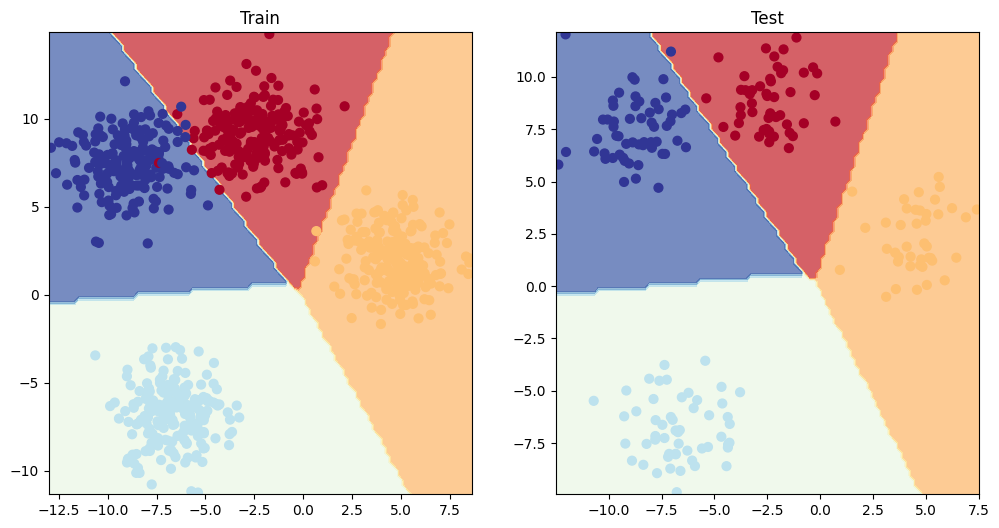

In [141]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

## 9. A few more classification metrics... (to evaluate our classification model)

* Accuracy - out of 100 samples, how many does the model get right?
* Precision
* Recall
* F1-score
* Confusion matrix
* Classification report

In [142]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 33.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 42.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 35.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 844.1 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

In [146]:
from torchmetrics import Accuracy
# Setup metric
torchmetric_accuracy = Accuracy(task="multiclass", num_classes=4)

# Calculate accuracy
torchmetric_accuracy(y_preds, y_blob_test)

tensor(0.9950)